In [1]:
# 导包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

Using TensorFlow backend.


In [2]:
# 读取数据
# 根据题意，先把header设置好
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']

# 读取训练集进入内存
train_data = pd.read_csv("data/adult_train.csv",names=headers)

# 对于测试集，他的第一行是一个分隔，不读入
test_data = pd.read_csv("data/adult_test.csv",names=headers,skiprows=[0])
test_data['income']= test_data['income'].apply(lambda x: x[0:-1])

In [3]:
train_data['source']='train'
test_data['source']='test'

In [4]:
# 合并数据一起进行预处理
data= pd.concat([train_data, test_data],axis=0,ignore_index=True)
train_data = train_data.replace('[?]', np.NaN, regex=True)
train_data.dropna(inplace=True)

In [5]:
# 对缺失数据进行处理，删除
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
source            0
dtype: int64

In [6]:
# 开始处理离散数据
# income我们需要将其映射一下
# 先将>=50K的映射成1，<=50K的设置为0
le= LabelEncoder()
data['income']= le.fit_transform(data['income'])
data['income'].value_counts()


0    37155
1    11687
Name: income, dtype: int64

In [7]:
# 取出所有的离散量属性,这些属性先不用看我们自定义的数据来源那一项
discrete = [x for x in data.columns if data[x].dtype=='object']
discrete.remove('source')
discrete

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [8]:
# 看看这些离散量属性的取值分布
for i in discrete:
    print(train_data[i].value_counts())
    

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64
 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64
 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital_status, dtype: int64
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Othe

In [9]:
# 看看education_num这个连续量
train_data['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

In [10]:
# 发现跟education一样的，重复了，因为eudcation是离散的，不好处理。去掉这个属性
data = data.drop(columns=['education'])

In [11]:
# 看看相关系数矩阵,检查一下连续变量。发现序号属性不太影响最后的收入
data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,0.230369
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,-0.006339
education_num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,0.332613
capital_gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,0.223013
capital_loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.147554
hours_per_week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.227687
income,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,1.000000


In [12]:
# 把序号属性删掉
data = data.drop(columns=['fnlwgt'])

In [13]:
discrete2 = [x for x in data.columns if data[x].dtype=='object']
discrete2.remove('source')
discrete2

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [14]:
# 进行哑编码
data = pd.get_dummies(data, columns=discrete2, drop_first=True)

In [15]:
# 看看编码后的结果
data.columns

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income', 'source', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-support',


In [16]:
# 将非2值类型的数据进行标准化
num = [x for x in data.columns if data[x].dtype=='int64']
num

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [17]:
scaler = StandardScaler()
data.loc[:, num] = scaler.fit_transform(data.loc[:, num])

In [18]:
train_data = data.loc[data['source']=='train',:]
test_data = data.loc[data['source']=='test',:]

In [19]:
# 把要预测的值income单独拿出来看看
y_train = np.array(train_data.income)
x_train = np.array(train_data.drop(['income','source'], axis=1))

y_test = np.array(test_data.income)
x_test = np.array(test_data.drop(['income','source'],axis=1))

In [20]:
clf = svm.SVC(gamma='scale')
clf.fit(x_train, y_train)
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred) * 100)

85.87924574657576


In [22]:
# 获得混淆矩阵
svm_confusion_matrix = confusion_matrix(y_pred, y_test)
svm_confusion_matrix


array([[11708,  1572],
       [  727,  2274]], dtype=int64)

Confusion matrix, without normalization
[[11708  1572]
 [  727  2274]]


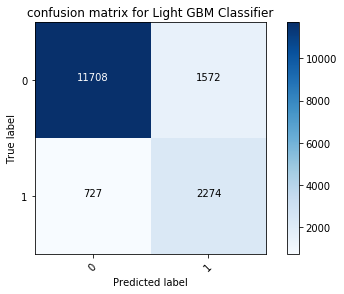

In [23]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(svm_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for Light GBM Classifier')